In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms, models
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)


PyTorch Version:  1.1.0
Torchvision Version:  0.2.2


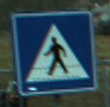

In [2]:
from PIL import Image
path = "../BelgiumTS/Training/00056/00303_00000.ppm"
path = "../BelgiumTS/Training/00056/00297_00002.ppm"
path = "../BelgiumTS/Training/00056/01200_00000.ppm"
display(Image.open(path))

In [3]:
data_dir = '/home/jzornig/devel/BelgiumTS/Training/'
def load_split_train_test(datadir, valid_size = .2):
    train_transforms = transforms.Compose([transforms.Resize((57,57)),
                                       transforms.ToTensor(),
                                       ])
    test_transforms = transforms.Compose([transforms.Resize((57,57)),
                                      transforms.ToTensor(),
                                      ])
    train_data = datasets.ImageFolder(datadir,       
                    transform=train_transforms)
    test_data = datasets.ImageFolder(datadir,
                    transform=test_transforms)
    num_train = len(train_data)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))
    np.random.shuffle(indices)
    from torch.utils.data.sampler import SubsetRandomSampler
    train_idx, test_idx = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_idx)
    test_sampler = SubsetRandomSampler(test_idx)
    trainloader = torch.utils.data.DataLoader(train_data,
                   sampler=train_sampler, batch_size=64)
    testloader = torch.utils.data.DataLoader(test_data,
                   sampler=test_sampler, batch_size=64)
    return trainloader, testloader
trainloader, testloader = load_split_train_test(data_dir, .2)
print(trainloader.dataset.classes)
print(len(trainloader.dataset.classes))

['00000', '00001', '00002', '00003', '00004', '00005', '00006', '00007', '00008', '00009', '00010', '00011', '00012', '00013', '00014', '00015', '00016', '00017', '00018', '00019', '00020', '00021', '00022', '00023', '00024', '00025', '00026', '00027', '00028', '00029', '00030', '00031', '00032', '00033', '00034', '00035', '00036', '00037', '00038', '00039', '00040', '00041', '00042', '00043', '00044', '00045', '00046', '00047', '00048', '00049', '00050', '00051', '00052', '00053', '00054', '00055', '00056', '00057', '00058', '00059', '00060', '00061']
62


In [4]:
import os
rootdir = '/home/jzornig/devel/BelgiumTS/Training/'

for subdir, dirs, files in os.walk(rootdir):
    for file in files:
        print(os.path.join(subdir, file))

/home/jzornig/devel/BelgiumTS/Training/Readme.txt
/home/jzornig/devel/BelgiumTS/Training/00000/01153_00000.ppm
/home/jzornig/devel/BelgiumTS/Training/00000/01153_00001.ppm
/home/jzornig/devel/BelgiumTS/Training/00000/01153_00002.ppm
/home/jzornig/devel/BelgiumTS/Training/00000/01160_00000.ppm
/home/jzornig/devel/BelgiumTS/Training/00000/01160_00001.ppm
/home/jzornig/devel/BelgiumTS/Training/00000/01160_00002.ppm
/home/jzornig/devel/BelgiumTS/Training/00000/01797_00000.ppm
/home/jzornig/devel/BelgiumTS/Training/00000/01797_00001.ppm
/home/jzornig/devel/BelgiumTS/Training/00000/01797_00002.ppm
/home/jzornig/devel/BelgiumTS/Training/00000/01798_00000.ppm
/home/jzornig/devel/BelgiumTS/Training/00000/01798_00001.ppm
/home/jzornig/devel/BelgiumTS/Training/00000/01798_00002.ppm
/home/jzornig/devel/BelgiumTS/Training/00000/01799_00000.ppm
/home/jzornig/devel/BelgiumTS/Training/00000/01799_00001.ppm
/home/jzornig/devel/BelgiumTS/Training/00000/01799_00002.ppm
/home/jzornig/devel/BelgiumTS/Train

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() 
                                  else "cpu")
model = models.vgg19(pretrained=True)
print(model)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /home/jzornig/.cache/torch/checkpoints/vgg19-dcbb9e9d.pth
100.0%


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (17): ReLU(inplace)

In [19]:
for param in model.parameters():
    param.requires_grad = True
    
model.fc = nn.Sequential(nn.Linear(2048, 512),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(512, 62),
                                 nn.LogSoftmax(dim=1))
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.003)
model.to(device)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (17): ReLU(inplace)

In [20]:
epochs = 10
steps = 0
running_loss = 0
print_every = 10
train_losses, test_losses = [], []
for epoch in range(epochs):
    for inputs, labels in trainloader:
        steps += 1
        
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        logps = model.forward(inputs)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
                
        if steps % print_every == 0:
            test_loss = 0
            accuracy = 0
            model.eval()
            with torch.no_grad():
                for inputs, labels in testloader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    logps = model.forward(inputs)
                    batch_loss = criterion(logps, labels)
                    test_loss += batch_loss.item()
                    
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
            train_losses.append(running_loss/len(trainloader))
            test_losses.append(test_loss/len(testloader))                    
            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"Test loss: {test_loss/len(testloader):.3f}.. "
                  f"Test accuracy: {accuracy/len(testloader):.3f}")
            running_loss = 0
            model.train()
torch.save(model, 'HelloPyTorch.pth')

Epoch 1/10.. Train loss: 2.418.. Test loss: 2.195.. Test accuracy: 0.000
Epoch 1/10.. Train loss: 2.356.. Test loss: 2.203.. Test accuracy: 0.000
Epoch 1/10.. Train loss: 2.330.. Test loss: 2.216.. Test accuracy: 0.000
Epoch 1/10.. Train loss: 2.544.. Test loss: 2.175.. Test accuracy: 0.000
Epoch 1/10.. Train loss: 2.523.. Test loss: 2.205.. Test accuracy: 0.000
Epoch 2/10.. Train loss: 2.516.. Test loss: 2.204.. Test accuracy: 0.000
Epoch 2/10.. Train loss: 2.443.. Test loss: 2.205.. Test accuracy: 0.000
Epoch 2/10.. Train loss: 2.314.. Test loss: 2.187.. Test accuracy: 0.000
Epoch 2/10.. Train loss: 2.650.. Test loss: 2.183.. Test accuracy: 0.000
Epoch 2/10.. Train loss: 2.647.. Test loss: 2.211.. Test accuracy: 0.000
Epoch 2/10.. Train loss: 2.295.. Test loss: 2.171.. Test accuracy: 0.000
Epoch 3/10.. Train loss: 2.515.. Test loss: 2.123.. Test accuracy: 0.000
Epoch 3/10.. Train loss: 2.389.. Test loss: 2.185.. Test accuracy: 0.000
Epoch 3/10.. Train loss: 2.643.. Test loss: 2.190..

In [ ]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)
plt.show()

In [ ]:
## save 
torch.save(model.state_dict(), "./HelloPyTorch_resnet50_weights.pt")